In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import scipy.io
import os

In [ ]:
# helper functions
def show(tensor, num):
  data = tensor.view(len(tensor), 1, 28, 28)
  data = data.detach().cpu()
  grid = make_grid(data[:num], nrow=4).permute(1,2,0).clip(0,1)
  plt.imshow(grid)
  plt.show()

In [ ]:
# Hyperparameters
batch_size = 128
device = device = ( 'cuda' if torch.cuda.is_available() else 'cpu' )

img_size = 784    # 28x28x1
hidden_dim = 400  # hidden layer dim
z_dim = 20        # latent space dimension (encoder)

epochs = 10

In [ ]:
# load dataset
transformation = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.MNIST(
    root = 'data',
    download = True,
    train = True,
    transform = transformation
)

testset = datasets.MNIST(
    root='data',
    download=True,
    train = False,
    transform = transformation
)

# dataloader
trainloader = DataLoader(
    dataset = trainset,
    shuffle = True,
    batch_size = batch_size
)

testloader = DataLoader(
    dataset = testset,
    shuffle = False,
    batch_size = batch_size
)

# folder to save images
sample_dir = 'results'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

100%|██████████| 9912422/9912422 [00:00<00:00, 42280828.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9936485.43it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11356702.95it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16171925.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# model architecture
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # encoder
    self.fc1 = nn.Linear(img_size, hidden_dim)
    self.fc2_mean = nn.Linear(hidden_dim, z_dim)
    self.fc2_logvar = nn.Linear(hidden_dim, z_dim)
    #decoder
    self.fc3 = nn.Linear(z_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, img_size)

  def encode(self, x):
    h = F.relu(self.fc1(x))
    mu = self.fc2_mean(h)         # compute mean of latent
    logvar = self.fc2_logvar(h)   # compute logvar of latent
    return mu, logvar

  def reparameterize(self, mu, logvar):
    # p(z|x) = mu + std * eps
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return (mu + eps * std)

  def decode(self, z):
    h = F.relu(self.fc3(z))
    out = torch.sigmoid(self.fc4(h))
    return out

  def forward(self, x):
    # batch_size x 1 x 28 x 28 -> batch_size x 784
    #print(x.view(-1, img_size).shape)
    mu, logvar = self.encode(x.view(-1, img_size))
    z = self.reparameterize(mu, logvar)
    reconstructed = self.decode(z)
    return reconstructed, mu, logvar

# Initialize model, optimizer
model = VAE().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define loss function
def loss_function(rec_img, org_img, mu, logvar):
  # Reconstruction loss
  rec_loss = F.binary_cross_entropy(rec_img, org_img.view(-1, img_size), reduction='sum')
  # KL-div loss
  kl_div = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
  #
  return rec_loss + kl_div

# train function
def train(epoch):

  # train function
  model.train()
  train_loss = 0

  for i, (images, _) in enumerate(trainloader):
    images = images.to(device)
    rec_img, mu, logvar = model(images)
    loss = loss_function(rec_img, images, mu, logvar)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss += loss.item()

    if i % 400 and i > 0:
      #print(f'epoch {epoch}, batch {i}/{len(trainloader)}, loss {loss.item()/len(images)}')
      pass

  print(f'----> Epoch {epoch}, Average loss {train_loss/len(trainloader.dataset)}')

# Test function
def test(epoch):
  model.eval()
  test_loss = 0

  with torch.no_grad():
    for i, (images, _) in enumerate(testloader):
      images = images.to(device)
      rec_img, mu, logvar = model(images)
      loss = loss_function(rec_img, images, mu, logvar)
      test_loss += loss.item()

      if i == 0:
        comparison = torch.cat([images[:5], rec_img.view(batch_size, 1, 28, 28)[:5]])
        save_image(comparison.cpu(), f'results/reconstruction_{epoch}.png', nrow=5)

    print(f'----> Average test loss {test_loss/len(testloader.dataset)}')

In [ ]:
# (Optional)

# save and load checkpoints
root_path='/content/drive/MyDrive/Colab/models'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optim.state_dict()
  }, f'{root_path}VAE-{name}.pkl')


  print('Saved checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}VAE-{name}.pkl')
  model.load_state_dict(checkpoint['model_state_dict'])
  optim.load_state_dict(checkpoint['optimizer_state_dict'])


  print('Loaded checkpoint')

In [ ]:
load_checkpoint(f'vae_model')

Loaded checkpoint


In [ ]:
noise = torch.randn(16, 20)
noise = noise.to(device)
epochs = 1000

# main function
for epoch in range(1, epochs+1):
  train(epoch)
  #test(epoch)
  with torch.no_grad():
    sample = torch.randn(64,20).to(device)
    generated = model.decode(sample).cpu()
    #save_image(generated.view(64,1,28,28), f'results/sample_{epoch}.png')
  if epoch % 50 == 0 and epoch > 0:
    save_checkpoint(f'vae_model')
    generated = model.decode(noise)
    show(generated, 16)

In [ ]:
save_checkpoint(f'vae_model')

Saved checkpoint


In [ ]:
### Testing latent space
testdat, labels = next(iter(trainloader))
for i in range(0, 30):
  testdat_temp, labels_temp = next(iter(trainloader))
  testdat = torch.cat([testdat,testdat_temp])
  labels = torch.cat([labels, labels_temp])


testdat = testdat.to(device)

_, mu, logvar = model(testdat)
z = model.reparameterize(mu, logvar).data.cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
z_emb = tsne.fit_transform(z)

<Axes: >

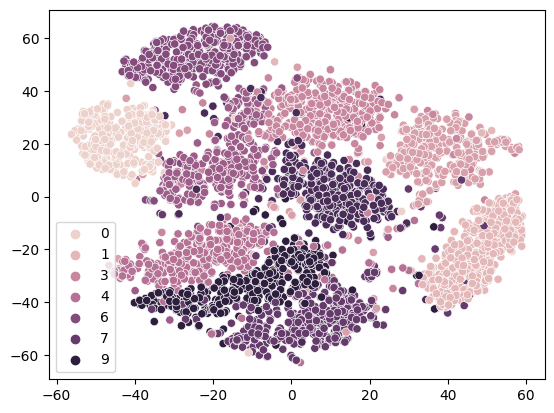

In [ ]:
import seaborn as sns
sns.scatterplot(x=z_emb[:, 0], y=z_emb[:, 1], hue = labels.cpu())